Compose(
    Resize(size=96, interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)
torch.Size([1, 96, 96])
<class 'matplotlib.axes._axes.Axes'>


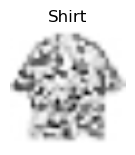

In [17]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils import data
from torchvision import transforms
from tqdm import tqdm
from torch.nn import functional as F

myseed = 1314  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

trans = [transforms.ToTensor()]
trans.insert(0,transforms.Resize(96))
trans = transforms.Compose(trans)
print(trans)
train_data = torchvision.datasets.FashionMNIST(
    root="./MNIST", train=True, transform=trans, download=True)
test_data  = torchvision.datasets.FashionMNIST(
    root="./MNIST", train=False, transform=trans, download=True)
device  = torch.device('cuda' if torch.cuda.is_available else 'cpu')

BATCH_SIZE = 128  

train_dataloader = data.DataLoader(dataset = train_data,batch_size = BATCH_SIZE,shuffle = True)
test_dataloader  = data.DataLoader(dataset = test_data,batch_size = 50)

class_str = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankel boot"]

def get_class(indices):
    return class_str[int(indices)]

def show_img(img,label,nrow,ncol,scale=1.5):
    fig,axes = plt.subplots(nrow,ncol, figsize=(ncol*scale,nrow*scale)) 
    if nrow*ncol == 1:
        axes = [axes, ]
    else:
        axes = axes.flatten()
    for i,(img,ax) in enumerate(zip(img,axes)):
        ax.imshow(img.squeeze(),cmap="Greys")
        ax.set_title(get_class(label[i]))
        ax.axis('off')
    plt.show()

x, y = next(iter(train_dataloader))
print(x[0].shape)
show_img(x,y,1,1)

def accuracy(y_pred,y):
    y_pred = y_pred.softmax(1).argmax(1)
    total = y.shape[0]
    right = (y_pred == y).sum()
    print("Acc:%.2f%%"%(right/total*100))
    return (right,total)


def train(train_loader,test_loader,model,n_epoch,lr,device):
    model.to(device)
    optim = torch.optim.SGD(model.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(n_epoch):
        bar = tqdm(train_loader,total=len(train_loader),unit_scale=BATCH_SIZE)
        for x,y in bar:
            optim.zero_grad()
            x,y = x.to(device),y.to(device)
            pred = model(x)
            loss = criterion(pred,y)
            loss.backward()
            optim.step()
            bar.set_description(f'Epoch:[{epoch+1:02d}/{n_epoch}]')
            bar.set_postfix(loss=float(loss))
        with torch.no_grad():
            for x,y in test_loader:
                x,y = x.to(device),y.to(device)
                pred = model(x)
                accuracy(pred,y)
                break

In [14]:
class Inception(nn.Module):
    # c1--c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [15]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Inception(
      (p1_1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (p2_1): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
      (p2_2): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (p3_1): Conv2d(192, 16, kernel_size=(1, 1), stride=(1, 1))
      (p3_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (p4_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (p4_2): Conv2d(192, 32, ker

In [16]:
train(train_dataloader,test_dataloader,net,10,0.1,device)

Epoch:[01/10]:   0%|          | 0/60032 [00:00<?, ?it/s]

Epoch:[01/10]:   7%|▋         | 4352/60032 [00:02<00:36, 1536.28it/s, loss=2.3] 


KeyboardInterrupt: 